In [1]:
!pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import researchpy as rc
import warnings
from scipy import stats

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('bikeshare.csv')

In [5]:
df.shape

(10886, 12)

In [6]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
df['atemp'].corr(df['temp'])

0.9849481104817068

Atemp and temp has correlation of 0.985. They are providing the same information. We will drop the atemp
feature and also datetime for our simplicity.

In [10]:
df.drop(['datetime', 'atemp'], axis=1, inplace=True)

In [11]:
df.apply(lambda x : x.nunique())

season          4
holiday         2
workingday      2
weather         4
temp           49
humidity       89
windspeed      28
casual        309
registered    731
count         822
dtype: int64

Standardize all the numerical features.

For this we will use scale function from sklearn library.

In [12]:
num_scaled = scale(df[['temp', 'humidity', 'windspeed', 'casual', 'registered']], copy=False)

Scale takes the difference of each values from the mean and divide by standard deviation

In [13]:
num_scaled

array([[-1.33366069,  0.99321305, -1.56775367, -0.66099193, -0.94385353],
       [-1.43890721,  0.94124921, -1.56775367, -0.56090822, -0.81805246],
       [-1.43890721,  0.94124921, -1.56775367, -0.62095844, -0.851158  ],
       ...,
       [-0.80742813, -0.04606385,  0.26970368, -0.64097518,  0.05593396],
       [-0.80742813, -0.04606385, -0.83244247, -0.48084125, -0.25525818],
       [-0.91267464,  0.21375537, -0.46560752, -0.64097518, -0.47375478]])

###Preparing Data for t-test

Now we will perform t-test to check whether the number of bike rentals are dependent on workingday or not. For
this we will use two sample t-test.
Two sample t-test is used to check whether the means of two samples(group) are same or different. We want to check whether the number of bikes rented on working day are different then number of bikes rented on non-
working days.

Let's check the mean of bikes rented on working and non-working days.

In [14]:
df.groupby('workingday')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


We can see that mean on working days is 193.0 and mean on the non-working day is 188.5. Definitely we can
see that there is difference in the means of working and non working days.
But the quetsion is, is this difference in the mean stastically significant or was it just due to random chance ?

Steps for performing hypothesis testing.
1. set up Null Hypothesis (H0)
2. State the alternate hypothesis (H1)
3. Set a significance level (alpha)
4. Calculate test Statistics.
5. Decision to accept or reject null hypothesis.

Create 2 samples one for working days and one for non-working days

In [15]:
sample_01 = df[df['workingday'] == 1]
sample_02 = df[df['workingday'] == 0]

In [16]:
#check the shape of both the samples
print(sample_01.shape,sample_02.shape)

(7412, 10) (3474, 10)


sample_01 have 7412 observations whereas sample_02 only have 3474 obsrvations. We have to take equal number of observations in both the sample.

In [17]:
#make equal number of records in each sample
sample_01 = sample_01.sample(3474)
print(sample_01.shape,sample_02.shape)

(3474, 10) (3474, 10)


Before directly jumping for hypothesis testing we have to check for different assumptions related to the kind of
hypothesis test we want to perform.
##Assumption for T-Test
1. The variances of the 2 samples are equal(We will use Levene's test to check this assumption).
2. The distrubtion of the residuals b/w the two groups should follow the normal distribution. We can plot
histogram and see whether the distribution follows the normal distribution or not. We can also plot a Q-Q
plot. We can check the normality using shapiro-wilks test as well.

###Levene's test to check whether the variances of the two group are same.
H0 : Variances are same.
H1 : Variances are not same.
Alpha = 0.05%
if p-value > alpha (Cannot reject H0)
if p-value < alpha (Accept null hypothesis)

In [18]:
alpha = 0.05
Stats,Pvalue = stats.levene(sample_01['count'],sample_01['count'])
print(f' Test statistics : {Stats} \n Alpha : {alpha} \n P-value : {Pvalue}')

if Pvalue > alpha:
  print(' Variances are same accept null hypothesis ')
else:
  print(' Variances are not same reject not null hypothesis ')

 Test statistics : 0.0 
 Alpha : 0.05 
 P-value : 1.0
 Variances are same accept null hypothesis 


Here we have got 2 things:
1. Test Statistics
2. And p-value assosciated with test stastics. We can see that p-value(1.0) > alpha(0.05). So we fail to reject
the null hypothesis. Variances of the 2 samples are equal.

###Check for normality
Take the difference between two samples and scale it to check the normality of the residuals.

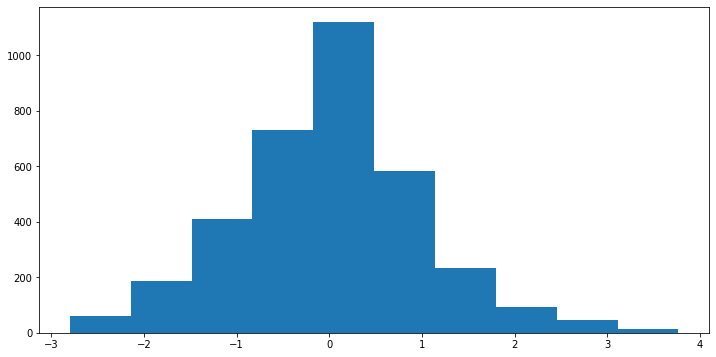

In [19]:
#we will take the difference b/w sample_01 and sample_02 and plot a histogram to check for normality
#we will scale the difference
diff = scale((np.array(sample_01['count']) - np.array(sample_02['count'])))
plt.figure(figsize=(12,6))
plt.hist(diff)
plt.show()

The distribution seems very close to normal distribution. Let's check other methods to check the normality of the
residuals.
Q-Q plot, Generates the a probability of sample data against the quantiles of theoretical distributions.

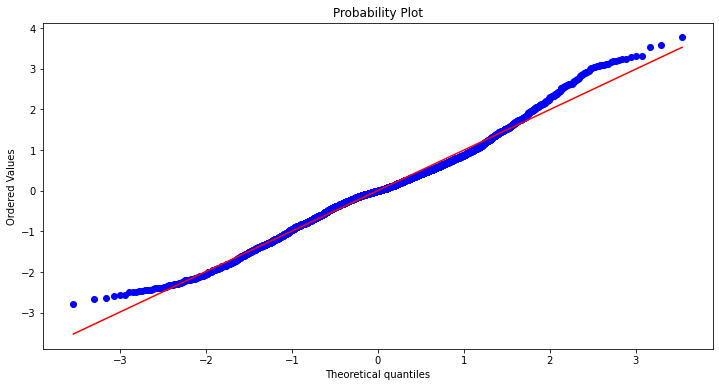

In [20]:
#q-q plot to check the normality
plt.figure(figsize=(12,6))
stats.probplot(diff,plot=plt,dist='norm')
plt.show()

When the points are closely follows the redline we can say that the residulas are normally distributed. Here we
see that after 2 standard deviation the points are scattered from redline. They doesn't follow the redline. But most
of the data points are still close to the redline so we accept the assumption of normality.
Till now we have seen graphical methods to represent to check the assumption of normality. Now let's check is it
with statstical test (Shapiro-Wilk Test)

In [22]:
#Stastical test for checking normality
#Shapiro-wilk test
#H0 : Normally distributed
#H1 : Not Normally distributed

alpha = 0.05
statistic,p_value = stats.shapiro(diff)
if p_value > alpha:
  print(f'Accept Null Hypothesis p-value : {p_value}')
else:
  print(f'Reject Null Hypothesis p-value : {p_value}')

Reject Null Hypothesis p-value : 2.025767173026937e-15


Here shapiro wilk test shows that the residuals are not normally distributed. for demonstration purpose We will
continue with t-test, but in practice we should not perform t-test when the assumption of normality is voilated.

##Independent Sample T-test

In [23]:
# H0 : There's no difference in mean (Bike rental doesn't depends on workingday)
# H1 : There's a difference in mean (Bike rental depends on workingday)
# Alpha : 0.05%
alpha = 0.05
statistic , p_value = stats.ttest_ind(sample_01['count'],sample_02['count'])
if p_value > alpha:
  print(f'Fail to reject Null Hypothesis p-value is {p_value}')
else:
  print('Reject Null Hypothesis')

Fail to reject Null Hypothesis p-value is 0.37960013461774234


As we can see that the p-value is greater than alpha. So we can't reject our null hypothesis.
working day has no effect on number of bikes rented.